## Import Libraries and Data

In [105]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.feature_selection import f_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.gofplots import qqplot
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import joblib
color_pal = sns.color_palette()

# Read the CSV file into Pandas DataFrame
data = pd.read_csv("Weather_data_2023_2024.csv", parse_dates=True, index_col="datetime")

## Data Exploration

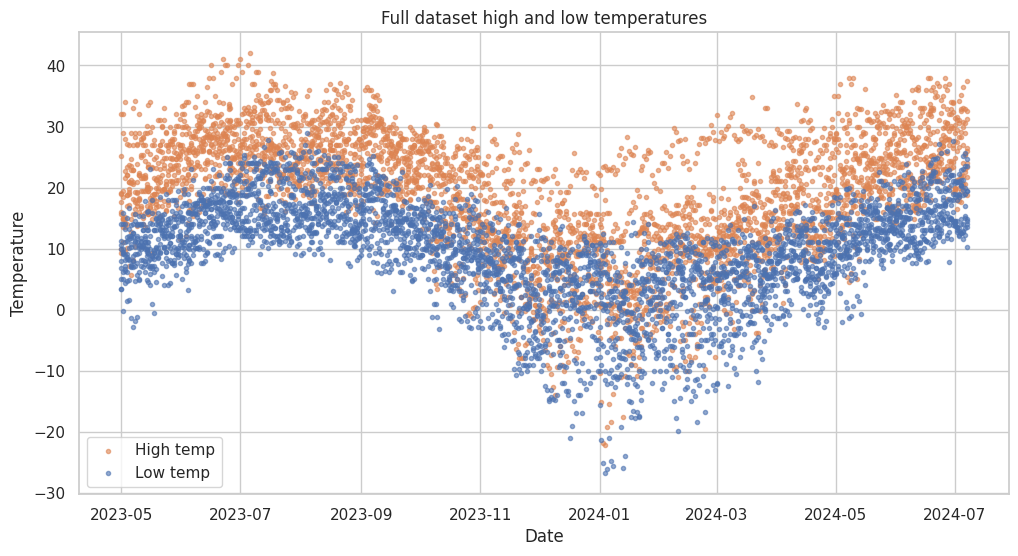

In [106]:
# Plot the tempmax and tempmin columns
fig, ax = plt.subplots(figsize=(12, 6))
plt.scatter(data.index, data['tempmax'], color=color_pal[1], label='High temp', alpha=0.6, marker='.')
plt.scatter(data.index, data['tempmin'], color=color_pal[0], label='Low temp', alpha=0.6, marker='.')

# Add titles and labels
plt.title('Full dataset high and low temperatures')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [107]:
print(data.shape)
data.isnull().sum()

(3906, 27)


location             0
tempmax              0
tempmin              0
temp                 0
feelslikemax         0
feelslikemin         0
feelslike            0
dew                  0
humidity             0
precip               0
precipprob           0
precipcover          0
snow                 0
snowdepth            0
windgust             0
windspeed            0
winddir              0
sealevelpressure     0
cloudcover           0
visibility           0
sunrise              0
sunset               0
moonphase            0
conditions           0
description          0
icon                 0
stations            53
dtype: int64

In [108]:
data.duplicated().sum()

0

In [109]:
# Drop Columns of No Interest
df = data.drop(columns=['stations', 'icon', 'description', 'conditions', 'sunset', 'sunrise'])

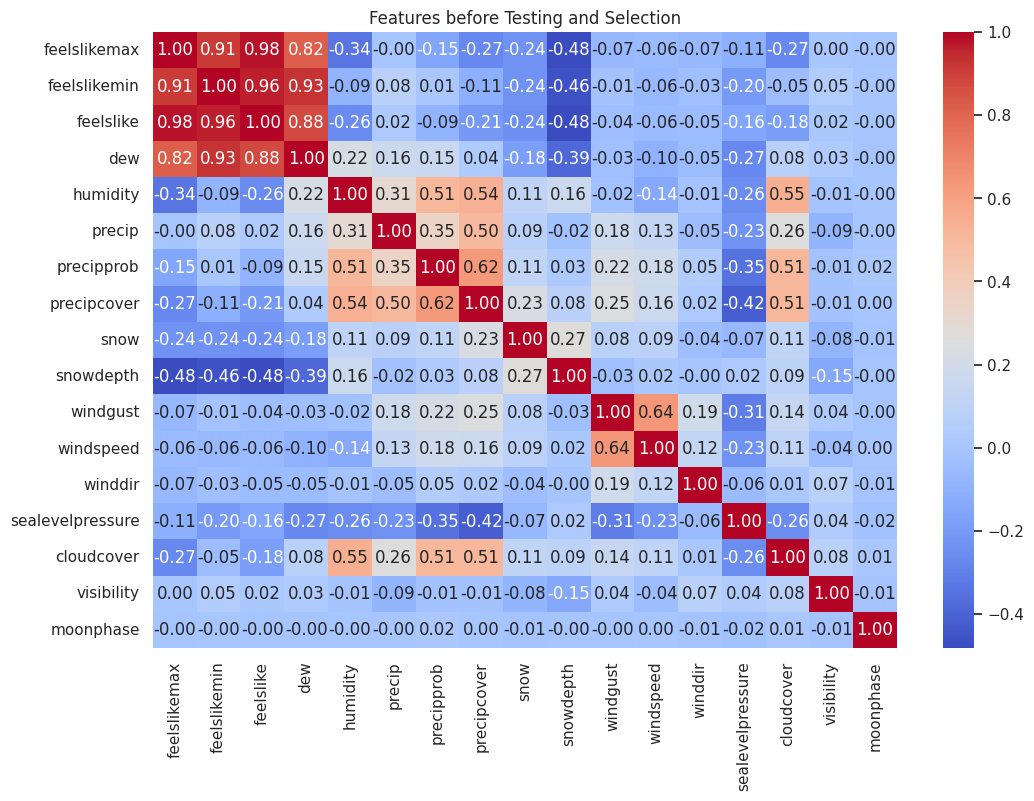

In [110]:
all_features = df[['feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'moonphase']]

df = df.select_dtypes(include=['number'])
correlation_matrix = all_features.corr()
plt.figure(figsize=(12, 8))
plt.title("Features before Testing and Selection")
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

## Feature Selection and Engineering

In [111]:
# Define the DataFrame with combined highly correlated features for tempmax and tempmin
df['feelslike_max_combined'] = df[['feelslikemax', 'feelslike']].mean(axis=1)
df['feelslike_min_combined'] = df[['feelslikemin', 'feelslike']].mean(axis=1)
df['dew_humidity'] = df[['dew', 'humidity']].mean(axis=1)

# Recalculate the features DataFrame without the original features tempmax
features_combined_max = df[['feelslike_max_combined', 'dew_humidity', 'snow', 'snowdepth', 'visibility']]

# Recalculate the features DataFrame without the original features tempmin
features_combined_min = df[['feelslike_min_combined', 'dew_humidity', 'precipcover', 'snowdepth', 'visibility']]


In [112]:
# Create lagged features
df['feelslike_max_combined_lag1'] = df['feelslike_max_combined'].shift(1)
df['dew_humidity_lag1'] = df['dew_humidity'].shift(1)
df['snow_lag1'] = df['snow'].shift(1)
df['snowdepth_lag1'] = df['snowdepth'].shift(1)

df['feelslike_min_combined_lag1'] = df['feelslike_min_combined'].shift(1)

# Drop NaN values that are introduced by the lag
df.dropna(inplace=True)

# Combine original features with their lagged counterparts by averaging
df['feelslike_max_combined_avg'] = (df['feelslike_max_combined'] + df['feelslike_max_combined_lag1']) / 2
df['dew_humidity_avg'] = (df['dew_humidity'] + df['dew_humidity_lag1']) / 2
df['snow_avg'] = (df['snow'] + df['snow_lag1']) / 2
df['snowdepth_avg'] = (df['snowdepth'] + df['snowdepth_lag1']) / 2

df['feelslike_min_combined_avg'] = (df['feelslike_min_combined'] + df['feelslike_min_combined_lag1']) / 2

# Define the new feature sets with averaged features
X_max_combined = df[['feelslike_max_combined_avg', 'dew_humidity_avg', 'snow_avg', 'snowdepth_avg']]
X_min_combined = df[['feelslike_min_combined_avg', 'dew_humidity_avg', 'snowdepth_avg', 'snow']]


In [113]:
""" Addressing Multicollinearity with Variance Inflation Factor"""
# Calculate VIF for each feature in tempmax
vif_data_max = pd.DataFrame()
vif_data_max["tempmax feature"] = X_max_combined.columns
vif_data_max["VIF"] = [variance_inflation_factor(X_max_combined.values, i) for i in range(X_max_combined.shape[1])]

# Calculate VIF for each feature in tempmin
vif_data_min = pd.DataFrame()
vif_data_min["tempmin feature"] = X_min_combined.columns
vif_data_min["VIF"] = [variance_inflation_factor(X_min_combined.values, i) for i in range(X_min_combined.shape[1])]

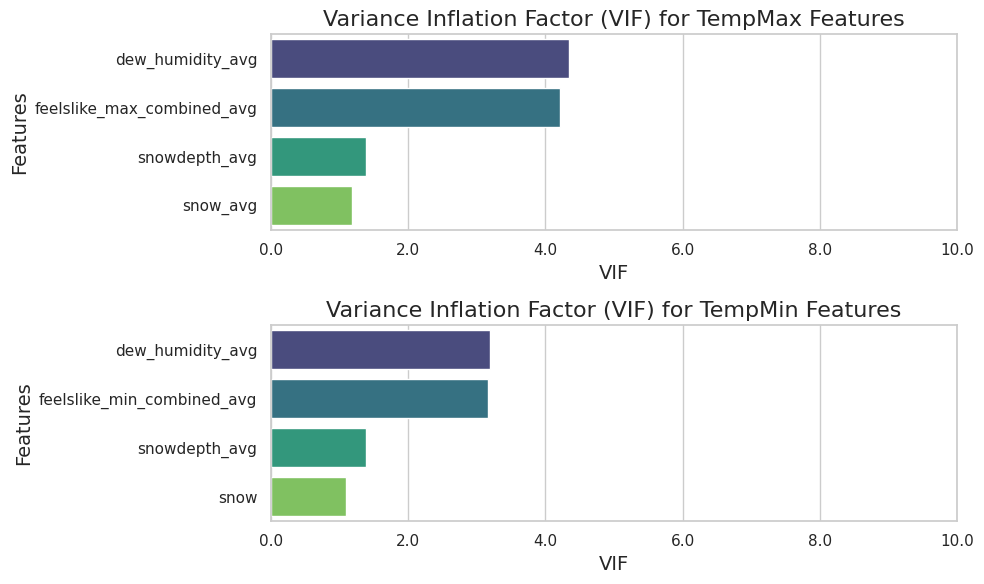

In [114]:
# Plotting the VIF results for tempmax and tempmin as subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))
sns.set(style="whitegrid")

# VIF for TempMax Features
sns.barplot(x="VIF", y="tempmax feature", hue="tempmax feature", dodge=False, data=vif_data_max.sort_values(by="VIF", ascending=False), palette="viridis", ax=axes[0], legend=False)
axes[0].set_title('Variance Inflation Factor (VIF) for TempMax Features', fontsize=16)
axes[0].set_xlabel('VIF', fontsize=14)
axes[0].set_ylabel('Features', fontsize=14)
axes[0].set_xlim(0, 10)
axes[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))

# VIF for TempMin Features
sns.barplot(x="VIF", y="tempmin feature", hue="tempmin feature", dodge=False, data=vif_data_min.sort_values(by="VIF", ascending=False), palette="viridis", ax=axes[1], legend=False)
axes[1].set_title('Variance Inflation Factor (VIF) for TempMin Features', fontsize=16)
axes[1].set_xlabel('VIF', fontsize=14)
axes[1].set_ylabel('Features', fontsize=14)
axes[1].set_xlim(0, 10)
axes[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))

# Adjust layout
plt.tight_layout()
plt.show()

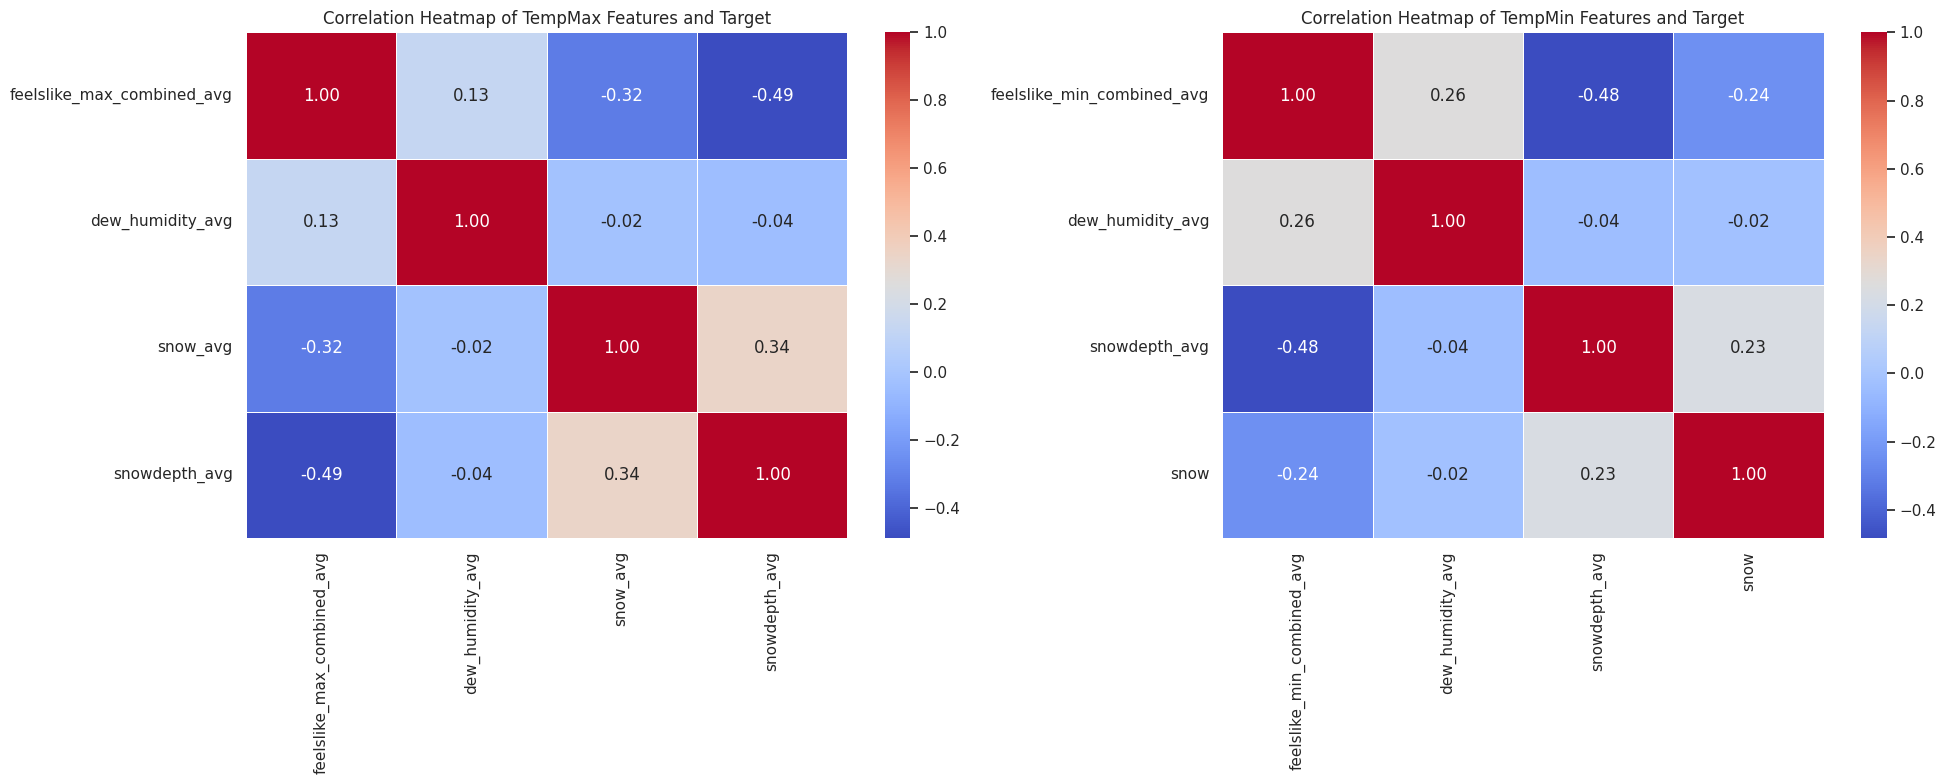

In [115]:
matrix_max = X_max_combined.corr()
matrix_min = X_min_combined.corr()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot heatmap for TempMax
sns.heatmap(matrix_max, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5, ax=axes[0])
axes[0].set_title('Correlation Heatmap of TempMax Features and Target')

# Plot heatmap for TempMin
sns.heatmap(matrix_min, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5, ax=axes[1])
axes[1].set_title('Correlation Heatmap of TempMin Features and Target')

plt.tight_layout()
plt.show()

## Hypothesis
"A higher dew point likely predicts a higher temperature across locations, making dew point a reliable temperature predictor irrespective of geography."

## Train-Validate-Test Split
### Translate Hypothesis to Testable Statements/Validate Features

In [116]:
# Define target variables
y_max = df['tempmax']
y_min = df['tempmin']

# Define feature set with combined features
X_max = ['feelslike_max_combined_avg', 'dew_humidity_avg', 'snow_avg', 'snowdepth_avg']
X_min = ['feelslike_min_combined_avg', 'dew_humidity_avg', 'snowdepth_avg']


In [117]:
# Define split dates
train_end_date = pd.to_datetime('2024-03-01')
validate_end_date = pd.to_datetime('2024-04-13')
test_start_date = pd.to_datetime('2024-04-13')

# Split the data into before and after the split date
train = df.loc[df.index < train_end_date]
validate = df.loc[(df.index >= train_end_date) & (df.index < validate_end_date)]
test = df.loc[df.index >= test_start_date]

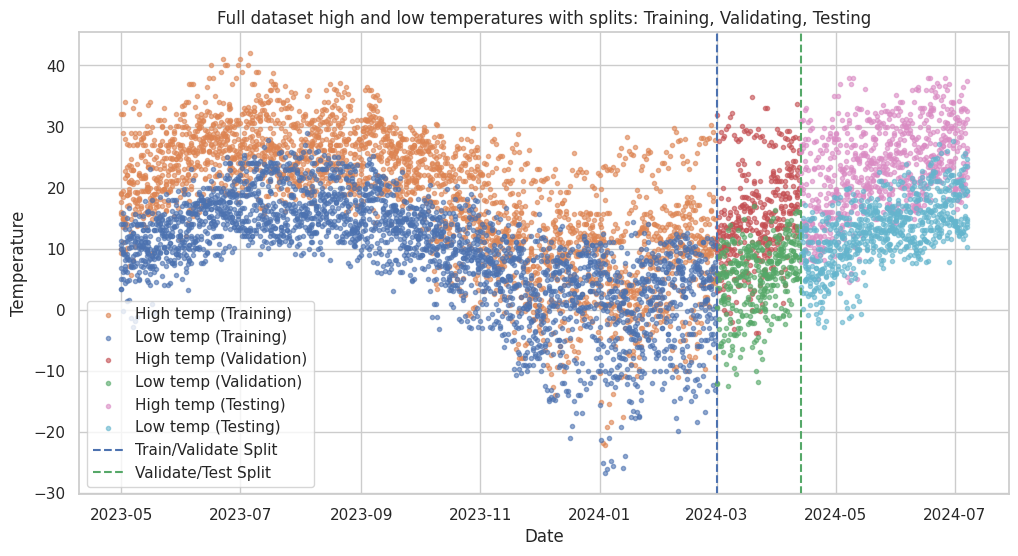

In [118]:
# Create the scatter plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the tempmax and tempmin columns for training data
plt.scatter(train.index, train['tempmax'], color=color_pal[1], label='High temp (Training)', alpha=0.6, marker='.')
plt.scatter(train.index, train['tempmin'], color=color_pal[0], label='Low temp (Training)', alpha=0.6, marker='.')

# Plot the tempmax and tempmin columns for validation data
plt.scatter(validate.index, validate['tempmax'], color=color_pal[3], label='High temp (Validation)', alpha=0.6, marker='.')
plt.scatter(validate.index, validate['tempmin'], color=color_pal[2], label='Low temp (Validation)', alpha=0.6, marker='.')

# Plot the tempmax and tempmin columns for testing data
plt.scatter(test.index, test['tempmax'], color=color_pal[6], label='High temp (Testing)', alpha=0.6, marker='.')
plt.scatter(test.index, test['tempmin'], color=color_pal[9], label='Low temp (Testing)', alpha=0.6, marker='.')

# Add titles and labels
plt.title('Full dataset high and low temperatures with splits: Training, Validating, Testing')
plt.xlabel('Date')
plt.ylabel('Temperature')

# Add vertical lines to mark the splits
ax.axvline(train_end_date, color=color_pal[0], ls='--', label='Train/Validate Split')
ax.axvline(validate_end_date, color=color_pal[2], ls='--', label='Validate/Test Split')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [119]:
# Define target variables
y_train_max = train['tempmax']
y_train_min = train['tempmin']
y_validate_max = validate['tempmax']
y_validate_min = validate['tempmin']
y_test_max = test['tempmax']
y_test_min = test['tempmin']

# Define feature sets tempmax
X_train_max = train[X_max]
X_validate_max = validate[X_max]
X_test_max = test[X_max]

# Define feature sets tempmin
X_train_min = train[X_min]
X_validate_min = validate[X_min]
X_test_min = test[X_min]

## Model Training and Evaluation
### Chose Ridge because of regularization needs to address overfitting after model cross validation

In [120]:
# Function to evaluate model with robust error metrics
def evaluate_model(X_train, y_train, X_test, y_test, model_name):
    # Fit the model using statsmodels for detailed analysis with robust standard errors
    X_train_sm = sm.add_constant(X_train)
    X_test_sm = sm.add_constant(X_test)
    model_sm = sm.OLS(y_train, X_train_sm).fit(cov_type='HC3')

    # Predictions
    y_train_pred = model_sm.predict(X_train_sm)
    y_test_pred = model_sm.predict(X_test_sm)

    # Goodness of fit
    print(f"Model Summary for {model_name}:")
    print(model_sm.summary())

    # Error metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    print(f'Train RMSE for {model_name}: {train_rmse}, Test RMSE: {test_rmse}')
    print(f'Train MAE for {model_name}: {train_mae}, Test MAE: {test_mae}')
    print(f'Train R² for {model_name}: {train_r2}, Test R²: {test_r2}')

    # Multicollinearity
    vif_data = pd.DataFrame()
    vif_data['feature'] = X_train.columns
    vif_data['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
    print(f"VIF for {model_name}:\n", vif_data)

    # Residual analysis
    residuals = y_train - y_train_pred

    # Create subplots for residual analysis, Q-Q plot, and autocorrelation of residuals
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # Residuals vs Predicted
    axs[0].scatter(y_train_pred, residuals)
    axs[0].axhline(0, color='red', linestyle='--')
    axs[0].set_xlabel('Predicted')
    axs[0].set_ylabel('Residuals')
    axs[0].set_title(f'Residuals vs Predicted for {model_name}')

    # Q-Q Plot
    qqplot(residuals, line='s', ax=axs[1])
    axs[1].set_title(f'Q-Q Plot of Residuals for {model_name}')

    # Autocorrelation of Residuals
    sm.graphics.tsa.plot_acf(residuals, lags=40, ax=axs[2])
    axs[2].set_title(f'Autocorrelation of Residuals for {model_name}')

    plt.tight_layout()
    plt.show()


In [121]:
# Initialize the scalers
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler

# Robust scaling the feature variables
scaler_max = RobustScaler()
scaler_min = RobustScaler()

# Fit and transform the training data
X_train_max_scaled = scaler_max.fit_transform(X_train_max)
X_train_min_scaled = scaler_min.fit_transform(X_train_min)

# Transform the test data using the same scaler
X_test_max_scaled = scaler_max.transform(X_test_max)
X_test_min_scaled = scaler_min.transform(X_test_min)

# Hyperparameter tuning using GridSearchCV for Ridge Regression
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

# GridSearchCV for tempmax
ridge_max = Ridge()
grid_search_max = GridSearchCV(ridge_max, param_grid, cv=5, scoring='r2')
grid_search_max.fit(X_train_max_scaled, y_train_max)
best_alpha_max = grid_search_max.best_params_['alpha']

# GridSearchCV for tempmin
ridge_min = Ridge()
grid_search_min = GridSearchCV(ridge_min, param_grid, cv=5, scoring='r2')
grid_search_min.fit(X_train_min_scaled, y_train_min)
best_alpha_min = grid_search_min.best_params_['alpha']

# Initialize and fit the Ridge Regression model with best alpha for tempmax
ridge_model_max = Ridge(alpha=best_alpha_max)
ridge_model_max.fit(X_train_max_scaled, y_train_max)

# Make predictions on the test set for tempmax
y_pred_test_max = ridge_model_max.predict(X_test_max_scaled)

# Calculate R² for test set for tempmax
r2_test_max = r2_score(y_test_max, y_pred_test_max)
print(f"Ridge Regression Test R² for tempmax: {r2_test_max}")

# Initialize and fit the Ridge Regression model with best alpha for tempmin
ridge_model_min = Ridge(alpha=best_alpha_min)
ridge_model_min.fit(X_train_min_scaled, y_train_min)

# Make predictions on the test set for tempmin
y_pred_test_min = ridge_model_min.predict(X_test_min_scaled)

# Calculate R² for test set for tempmin
r2_test_min = r2_score(y_test_min, y_pred_test_min)
print(f"Ridge Regression Test R² for tempmin: {r2_test_min}")

# Calculate residuals
residuals_max = y_test_max - y_pred_test_max
residuals_min = y_test_min - y_pred_test_min


Ridge Regression Test R² for tempmax: 0.9126060922533974
Ridge Regression Test R² for tempmin: 0.9134724443476788


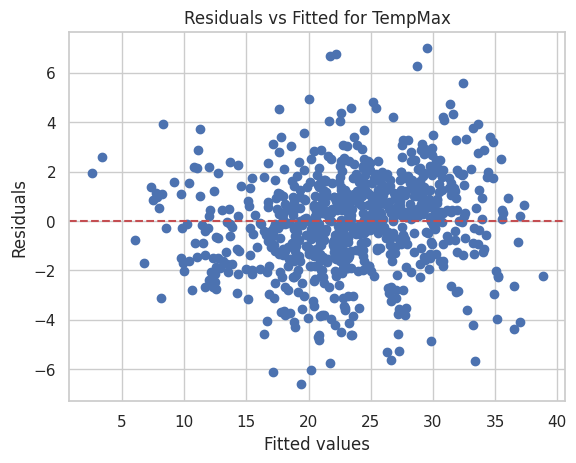

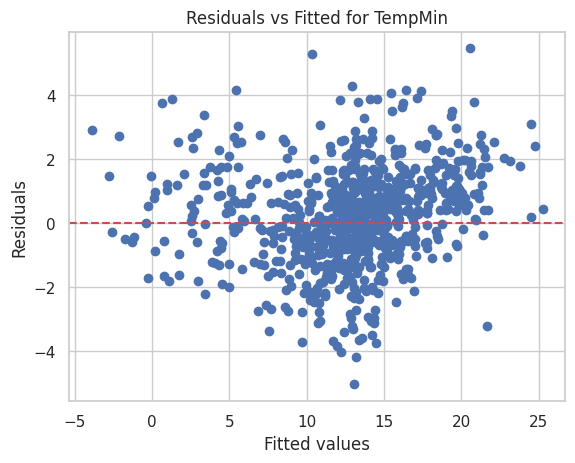

Durbin-Watson Statistic for TempMax Residuals: 1.7390073765595522
Durbin-Watson Statistic for TempMin Residuals: 1.9122074672508103
Breusch-Pagan Test for TempMax: {'Lagrange multiplier statistic': 0.9706779723102801, 'p-value': 0.3245111527631443, 'f-value': 0.9693854725431867, 'f p-value': 0.32514195114658395}
Breusch-Pagan Test for TempMin: {'Lagrange multiplier statistic': 6.480331577759237, 'p-value': 0.010907463421131209, 'f-value': 6.518159968869915, 'f p-value': 0.010869083443845762}
Breusch-Pagan Test for TempMax: {'Lagrange multiplier statistic': 0.9706779723102801, 'p-value': 0.3245111527631443, 'f-value': 0.9693854725431867, 'f p-value': 0.32514195114658395}
Breusch-Pagan Test for TempMin: {'Lagrange multiplier statistic': 6.480331577759237, 'p-value': 0.010907463421131209, 'f-value': 6.518159968869915, 'f p-value': 0.010869083443845762}
Shapiro-Wilk Test for TempMax Residuals: W=0.9928226569376348, p-value=0.0008779594720370181
Shapiro-Wilk Test for TempMin Residuals: W=0.

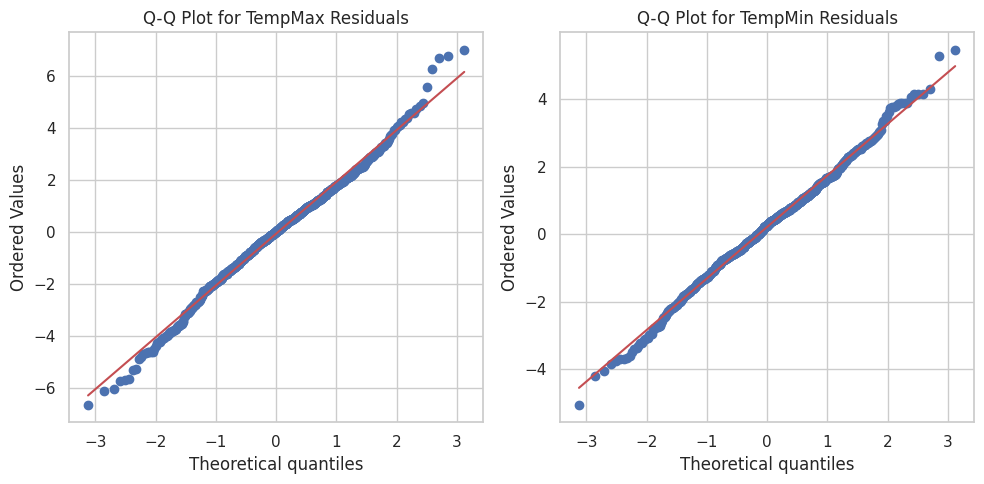

VIF for TempMax Features: 
                      feature       VIF
0  feelslike_max_combined_avg  1.537378
1            dew_humidity_avg  1.071542
2                    snow_avg  1.249297
3               snowdepth_avg  1.521655
VIF for TempMin Features: 
                      feature       VIF
0  feelslike_min_combined_avg  1.593371
1            dew_humidity_avg  1.159371
2               snowdepth_avg  1.405562


In [122]:
import matplotlib.pyplot as plt

plt.scatter(y_pred_test_max, residuals_max)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Fitted for TempMax')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

plt.scatter(y_pred_test_min, residuals_min)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Fitted for TempMin')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()
from statsmodels.stats.stattools import durbin_watson

dw_stat_max = durbin_watson(residuals_max)
dw_stat_min = durbin_watson(residuals_min)

print(f'Durbin-Watson Statistic for TempMax Residuals: {dw_stat_max}')
print(f'Durbin-Watson Statistic for TempMin Residuals: {dw_stat_min}')
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.compat import lzip
import statsmodels.api as sm

# For TempMax
test_max = sm.OLS(residuals_max, sm.add_constant(y_pred_test_max)).fit()
bp_test_max = het_breuschpagan(test_max.resid, test_max.model.exog)
names = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
lzip(names, bp_test_max)
print(f'Breusch-Pagan Test for TempMax: {dict(lzip(names, bp_test_max))}')

# For TempMin
test_min = sm.OLS(residuals_min, sm.add_constant(y_pred_test_min)).fit()
bp_test_min = het_breuschpagan(test_min.resid, test_min.model.exog)
lzip(names, bp_test_min)
print(f'Breusch-Pagan Test for TempMin: {dict(lzip(names, bp_test_min))}')
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.compat import lzip
import statsmodels.api as sm

# For TempMax
test_max = sm.OLS(residuals_max, sm.add_constant(y_pred_test_max)).fit()
bp_test_max = het_breuschpagan(test_max.resid, test_max.model.exog)
names = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
lzip(names, bp_test_max)
print(f'Breusch-Pagan Test for TempMax: {dict(lzip(names, bp_test_max))}')

# For TempMin
test_min = sm.OLS(residuals_min, sm.add_constant(y_pred_test_min)).fit()
bp_test_min = het_breuschpagan(test_min.resid, test_min.model.exog)
lzip(names, bp_test_min)
print(f'Breusch-Pagan Test for TempMin: {dict(lzip(names, bp_test_min))}')

from scipy.stats import shapiro, probplot

# Shapiro-Wilk Test
shapiro_max = shapiro(residuals_max)
shapiro_min = shapiro(residuals_min)
print(f'Shapiro-Wilk Test for TempMax Residuals: W={shapiro_max[0]}, p-value={shapiro_max[1]}')
print(f'Shapiro-Wilk Test for TempMin Residuals: W={shapiro_min[0]}, p-value={shapiro_min[1]}')

# Q-Q Plot
plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
probplot(residuals_max, dist="norm", plot=plt)
plt.title('Q-Q Plot for TempMax Residuals')

plt.subplot(1, 2, 2)
probplot(residuals_min, dist="norm", plot=plt)
plt.title('Q-Q Plot for TempMin Residuals')

plt.tight_layout()
plt.show()
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming X_train_max_scaled and X_train_min_scaled are DataFrames
vif_data_max = pd.DataFrame()
vif_data_max["feature"] = X_train_max.columns
vif_data_max["VIF"] = [variance_inflation_factor(X_train_max_scaled, i) for i in range(X_train_max_scaled.shape[1])]

vif_data_min = pd.DataFrame()
vif_data_min["feature"] = X_train_min.columns
vif_data_min["VIF"] = [variance_inflation_factor(X_train_min_scaled, i) for i in range(X_train_min_scaled.shape[1])]

print(f'VIF for TempMax Features: \n{vif_data_max}')
print(f'VIF for TempMin Features: \n{vif_data_min}')


In [123]:
# Calculate RMSE for TempMax Ridge
rmse_test_max = np.sqrt(mean_squared_error(y_test_max, y_pred_test_max))
print(f'RMSE for Ridge TempMax: {rmse_test_max}')

# Calculate RMSE for TempMax Ridge
rmse_test_min = np.sqrt(mean_squared_error(y_test_min, y_pred_test_min))
print(f'RMSE for Ridge TempMax: {rmse_test_min}')

RMSE for Ridge TempMax: 1.989340788164538
RMSE for Ridge TempMax: 1.5376085305671487


In [124]:
from scipy.stats import shapiro

# Test normality for a specific feature
stat_max, p_value_max = shapiro(df['feelslike_max_combined_avg'])
stat_min, p_value_min = shapiro(df['feelslike_min_combined_avg'])

print(f"Shapiro-Wilk Test Max: W={stat_max}, p-value={p_value_max}")
print(f"Shapiro-Wilk Test Min: W={stat_min}, p-value={p_value_min}")

if p_value_max > 0.05:
    print("Max The data follows a normal distribution (fail to reject H0).")
else:
    print("The data does not follow a normal distribution (reject H0).")
if p_value_min > 0.05:
    print("Min The data follows a normal distribution (fail to reject H0).")
else:
    print("The data does not follow a normal distribution (reject H0).")


Shapiro-Wilk Test Max: W=0.9517762504705003, p-value=4.698694751308984e-34
Shapiro-Wilk Test Min: W=0.9440124910862234, p-value=3.818245020802864e-36
The data does not follow a normal distribution (reject H0).
The data does not follow a normal distribution (reject H0).


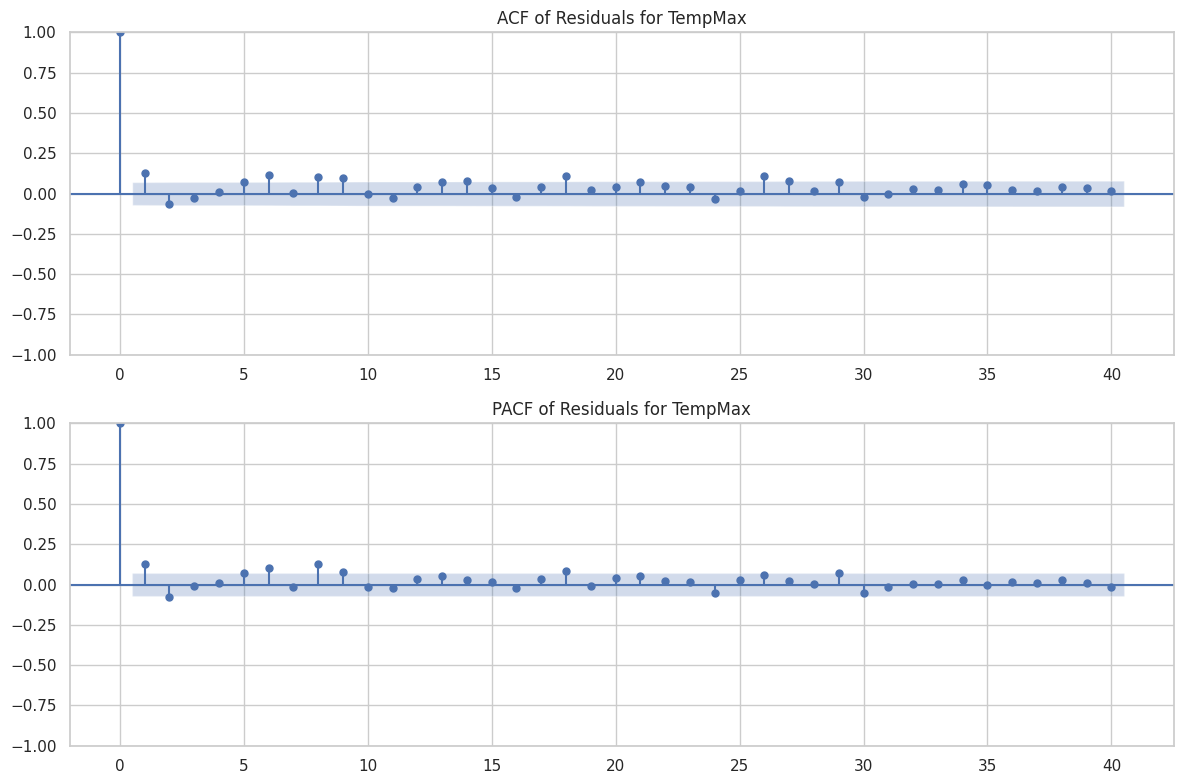

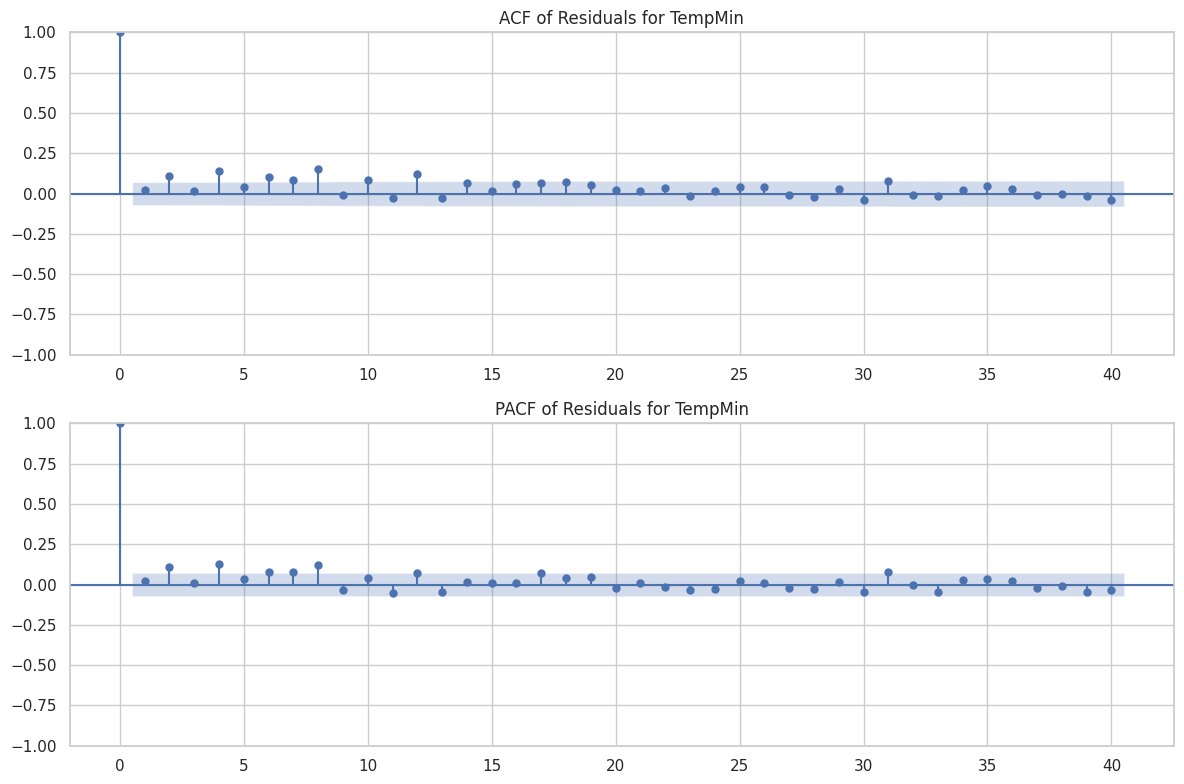

In [125]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF and PACF for TempMax residuals
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(residuals_max, lags=40, ax=ax[0], title='ACF of Residuals for TempMax')
plot_pacf(residuals_max, lags=40, ax=ax[1], title='PACF of Residuals for TempMax')
plt.tight_layout()
plt.show()

# ACF and PACF for TempMin residuals
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(residuals_min, lags=40, ax=ax[0], title='ACF of Residuals for TempMin')
plot_pacf(residuals_min, lags=40, ax=ax[1], title='PACF of Residuals for TempMin')
plt.tight_layout()
plt.show()


In [126]:
from statsmodels.tsa.stattools import adfuller

# Function to perform ADF test
def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna())
    labels = ['ADF Test Statistic', 'p-value', '# Lags Used', '# Observations Used']
    out = pd.Series(result[0:4], index=labels)
    for key, value in result[4].items():
        out[f'Critical Value ({key})'] = value
    print(out.to_string())
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis, fail to reject the null hypothesis. Data has a unit root and is non-stationary")
    print()

# Perform ADF test on target variables
adf_test(df['tempmax'], title='TempMax')
adf_test(df['tempmin'], title='TempMin')


Augmented Dickey-Fuller Test: TempMax
ADF Test Statistic        -4.211812
p-value                    0.000629
# Lags Used               13.000000
# Observations Used     3891.000000
Critical Value (1%)       -3.432032
Critical Value (5%)       -2.862283
Critical Value (10%)      -2.567166
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary

Augmented Dickey-Fuller Test: TempMin
ADF Test Statistic        -4.249961
p-value                    0.000542
# Lags Used               16.000000
# Observations Used     3888.000000
Critical Value (1%)       -3.432033
Critical Value (5%)       -2.862284
Critical Value (10%)      -2.567166
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary



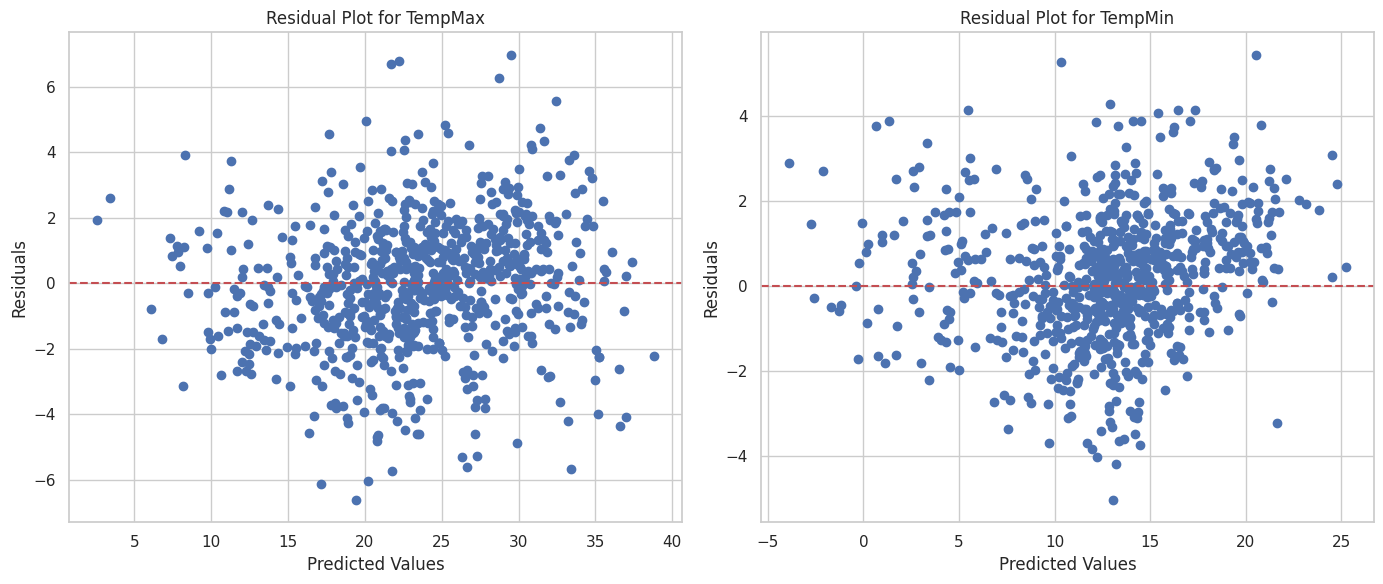

In [127]:
import matplotlib.pyplot as plt
import seaborn as sns

# Residual plots for TempMax
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_pred_test_max, residuals_max)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot for TempMax')

# Residual plots for TempMin
plt.subplot(1, 2, 2)
plt.scatter(y_pred_test_min, residuals_min)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot for TempMin')

plt.tight_layout()
plt.show()


In [128]:
from statsmodels.stats.stattools import durbin_watson

# Compute Durbin-Watson statistic
dw_stat_max = durbin_watson(residuals_max)
dw_stat_min = durbin_watson(residuals_min)

print(f'Durbin-Watson Statistic for TempMax Residuals: {dw_stat_max}')
print(f'Durbin-Watson Statistic for TempMin Residuals: {dw_stat_min}')

Durbin-Watson Statistic for TempMax Residuals: 1.7390073765595522
Durbin-Watson Statistic for TempMin Residuals: 1.9122074672508103


## Feature Importance

In [129]:
# Feature importances for TempMax
importance_max = ridge_model_max.coef_
features_max = X_train_max.columns
importance_df_max = pd.DataFrame({'Feature': features_max, 'Importance': importance_max}).sort_values(by='Importance', ascending=False)
print("Feature Importances for TempMax:")
print(importance_df_max)

# Feature importances for TempMin
importance_min = ridge_model_min.coef_
features_min = X_train_min.columns
importance_df_min = pd.DataFrame({'Feature': features_min, 'Importance': importance_min}).sort_values(by='Importance', ascending=False)
print("Feature Importances for TempMin:")
print(importance_df_min)


Feature Importances for TempMax:
                      Feature  Importance
0  feelslike_max_combined_avg   13.424232
2                    snow_avg    0.155735
3               snowdepth_avg    0.052224
1            dew_humidity_avg   -1.149610
Feature Importances for TempMin:
                      Feature  Importance
0  feelslike_min_combined_avg   10.322855
1            dew_humidity_avg    1.115168
2               snowdepth_avg    0.027964


In [130]:
# Feature importances for tempmax
importances_max = abs(ridge_model_max.coef_)
importance_df_max = pd.DataFrame({
    'Feature': X_train_max.columns,
    'Importance': importances_max
}).sort_values(by='Importance', ascending=False)

# Feature importances for tempmin
importances_min = abs(ridge_model_min.coef_)
importance_df_min = pd.DataFrame({
    'Feature': X_train_min.columns,
    'Importance': importances_min
}).sort_values(by='Importance', ascending=False)

print("Feature Importances from Ridge Regression for tempmax:")
print(importance_df_max)

print("Feature Importances from Ridge Regression for tempmin:")
print(importance_df_min)

Feature Importances from Ridge Regression for tempmax:
                      Feature  Importance
0  feelslike_max_combined_avg   13.424232
1            dew_humidity_avg    1.149610
2                    snow_avg    0.155735
3               snowdepth_avg    0.052224
Feature Importances from Ridge Regression for tempmin:
                      Feature  Importance
0  feelslike_min_combined_avg   10.322855
1            dew_humidity_avg    1.115168
2               snowdepth_avg    0.027964


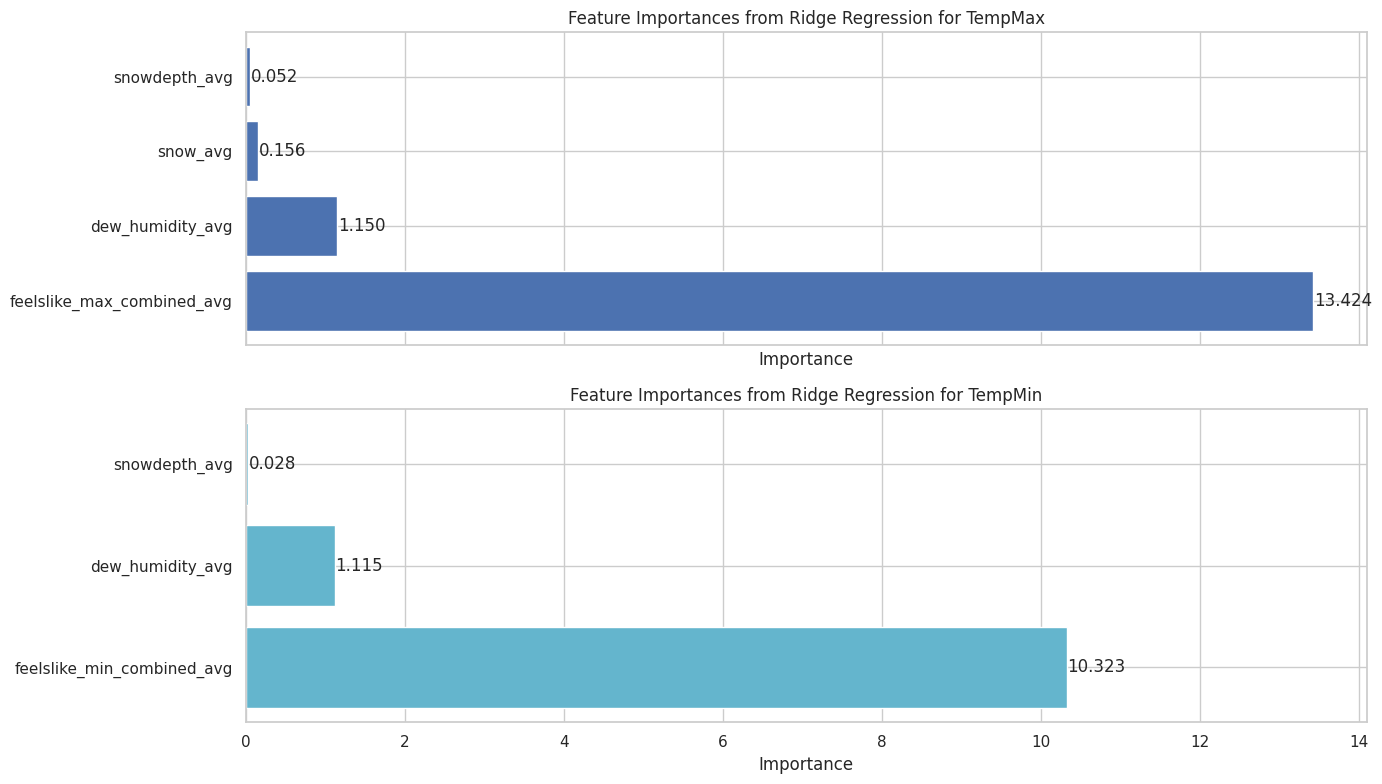

In [131]:
# Plot
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14, 8), sharex=True)

# TempMax Plot
ax1.barh(importance_df_max['Feature'], importance_df_max['Importance'], color=color_pal[0])
ax1.set_title('Feature Importances from Ridge Regression for TempMax')
ax1.set_xlabel('Importance')
for index, value in enumerate(importance_df_max['Importance']):
    ax1.text(value + 0.01, index, f'{value:.3f}', va='center')

# TempMin Plot
ax2.barh(importance_df_min['Feature'], importance_df_min['Importance'], color=color_pal[9])
ax2.set_title('Feature Importances from Ridge Regression for TempMin')
ax2.set_xlabel('Importance')
for index, value in enumerate(importance_df_min['Importance']):
    ax2.text(value + 0.01, index, f'{value:.3f}', va='center')

# Adjust layout
plt.tight_layout()
plt.show()

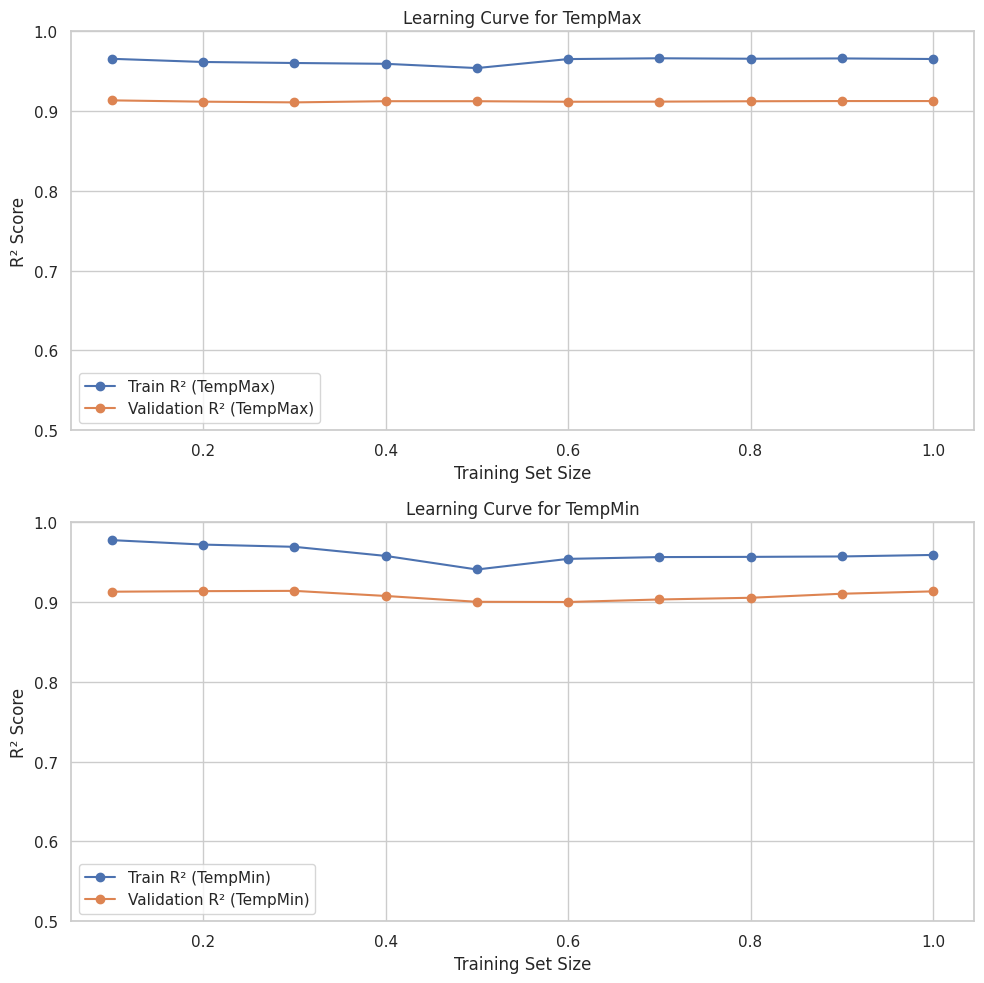

In [132]:
# List to store results
train_sizes = np.linspace(0.1, 1.0, 10)
train_r2_max = []
val_r2_max = []
train_r2_min = []
val_r2_min = []

for train_size in train_sizes:
    # Calculate the number of samples for the current training subset size
    subset_size_max = int(train_size * len(X_train_max_scaled))
    subset_size_min = int(train_size * len(X_train_min_scaled))

    # Create training subsets
    X_train_max_subset = X_train_max_scaled[:subset_size_max]
    y_train_max_subset = y_train_max.iloc[:subset_size_max]

    X_train_min_subset = X_train_min_scaled[:subset_size_min]
    y_train_min_subset = y_train_min.iloc[:subset_size_min]

    # Initialize and fit the Ridge Regression model
    ridge_model_max = Ridge(alpha=best_alpha_max)
    ridge_model_max.fit(X_train_max_subset, y_train_max_subset)

    ridge_model_min = Ridge(alpha=best_alpha_min)
    ridge_model_min.fit(X_train_min_subset, y_train_min_subset)

    # Predict and evaluate
    y_train_pred_max = ridge_model_max.predict(X_train_max_subset)
    y_val_pred_max = ridge_model_max.predict(X_test_max_scaled)

    y_train_pred_min = ridge_model_min.predict(X_train_min_subset)
    y_val_pred_min = ridge_model_min.predict(X_test_min_scaled)

    # Compute R²
    train_r2_max.append(r2_score(y_train_max_subset, y_train_pred_max))
    val_r2_max.append(r2_score(y_test_max, y_val_pred_max))

    train_r2_min.append(r2_score(y_train_min_subset, y_train_pred_min))
    val_r2_min.append(r2_score(y_test_min, y_val_pred_min))

# Plot learning curves
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# TempMax Learning Curve
ax[0].plot(train_sizes, train_r2_max, label='Train R² (TempMax)', marker='o')
ax[0].plot(train_sizes, val_r2_max, label='Validation R² (TempMax)', marker='o')
ax[0].set_title('Learning Curve for TempMax')
ax[0].set_xlabel('Training Set Size')
ax[0].set_ylabel('R² Score')
ax[0].legend()
ax[0].grid(True)
ax[0].set_ylim(0.5, 1.0)  # Set y-axis limit for TempMax

# TempMin Learning Curve
ax[1].plot(train_sizes, train_r2_min, label='Train R² (TempMin)', marker='o')
ax[1].plot(train_sizes, val_r2_min, label='Validation R² (TempMin)', marker='o')
ax[1].set_title('Learning Curve for TempMin')
ax[1].set_xlabel('Training Set Size')
ax[1].set_ylabel('R² Score')
ax[1].legend()
ax[1].grid(True)
ax[1].set_ylim(0.5, 1.0)  # Set y-axis limit for TempMin

plt.tight_layout()
plt.show()

## Autocorrelation

In [133]:
import pmdarima as pm
from statsmodels.stats.stattools import durbin_watson
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")

# Auto ARIMA to find best model orders
stepwise_fit_max = pm.auto_arima(y_train_max, exogenous=X_train_max, trace=True, suppress_warnings=True)
stepwise_fit_min = pm.auto_arima(y_train_min, exogenous=X_train_min, trace=True, suppress_warnings=True)

print("------------------- ARIMA MAX -----------------")
print(stepwise_fit_max.summary())
print("------------------- ARIMA MIN -----------------")
print(stepwise_fit_min.summary())

# Train and fit the models on best orders based on auto_arima results
arima_max = ARIMA(y_train_max, order=stepwise_fit_max.order, exog=X_train_max)
arima_max = arima_max.fit()
print(arima_max.summary())

arima_min = ARIMA(y_train_min, order=stepwise_fit_min.order, exog=X_train_min)
arima_min = arima_min.fit()
print(arima_min.summary())

# Define start and end points for prediction
start = len(y_train_max)
end = start + len(y_test_max) - 1

# Predict using the ARIMA models
arima_pred_max = arima_max.predict(start=start, end=end, exog=X_test_max, typ='levels')
arima_pred_min = arima_min.predict(start=start, end=end, exog=X_test_min, typ='levels')

# Ensure the predictions have the correct index
arima_pred_max.index = y_test_max.index
arima_pred_min.index = y_test_min.index


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=13803.592, Time=1.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14001.265, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13969.182, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13952.246, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13999.279, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=13801.658, Time=0.57 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=13855.585, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13806.953, Time=0.42 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=13803.511, Time=1.36 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=13818.322, Time=0.55 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=13801.945, Time=0.47 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=13805.642, Time=0.91 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=13799.715, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=13853.609, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0

In [134]:
# Calculate RMSE for TempMax ARIMA
arima_rmse_max = np.sqrt(mean_squared_error(y_test_max, arima_pred_max))
print(f'RMSE for ARIMA TempMax: {arima_rmse_max}')

# Calculate RMSE for TempMin ARIMA
arima_rmse_min = np.sqrt(mean_squared_error(y_test_min, arima_pred_min))
print(f'RMSE for ARIMA TempMin: {arima_rmse_min}')

# Calculate RMSE for TempMax Ridge
rmse_max = np.sqrt(mean_squared_error(y_test_max, y_pred_test_max))
print(f'RMSE for Ridge TempMax: {rmse_max}')

# Calculate RMSE for TempMin Ridge
rmse_min = np.sqrt(mean_squared_error(y_test_min, y_pred_test_min))
print(f'RMSE for Ridge TempMin: {rmse_min}')

RMSE for ARIMA TempMax: 2.118788383528425
RMSE for ARIMA TempMin: 1.5768147777033734
RMSE for Ridge TempMax: 1.989340788164538
RMSE for Ridge TempMin: 1.5376085305671487


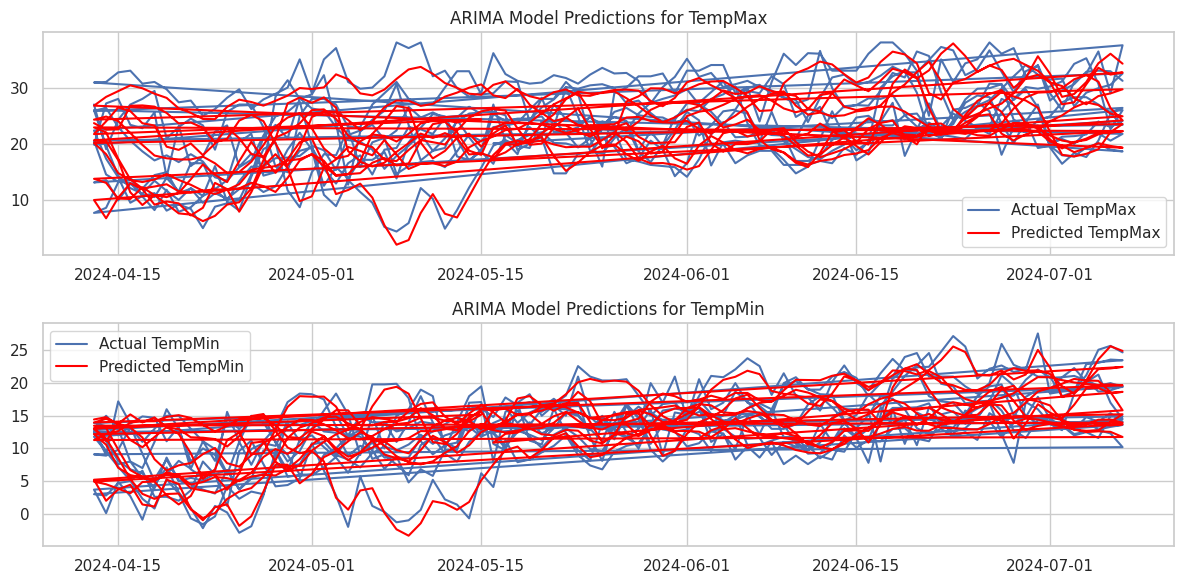

In [135]:
# Plot the predicted ARIMA values against the validate values
plt.figure(figsize=(12, 6))

# TempMax predictions
plt.subplot(2, 1, 1)
plt.plot(y_test_max, label='Actual TempMax')
plt.plot(arima_pred_max, label='Predicted TempMax', color='red')
plt.title('ARIMA Model Predictions for TempMax')
plt.legend()

# TempMin predictions
plt.subplot(2, 1, 2)
plt.plot(y_test_min, label='Actual TempMin')
plt.plot(arima_pred_min, label='Predicted TempMin', color='red')
plt.title('ARIMA Model Predictions for TempMin')
plt.legend()

plt.tight_layout()
plt.show()

In [136]:
from statsmodels.stats.stattools import durbin_watson

# Compute Durbin-Watson statistic
dw_stat_max = durbin_watson(residuals_max)
dw_stat_min = durbin_watson(residuals_min)

print(f'Durbin-Watson Statistic for TempMax Residuals: {dw_stat_max}')
print(f'Durbin-Watson Statistic for TempMin Residuals: {dw_stat_min}')


Durbin-Watson Statistic for TempMax Residuals: 1.7390073765595522
Durbin-Watson Statistic for TempMin Residuals: 1.9122074672508103


## Hybrid

In [137]:
import pmdarima as pm

# Fit ARIMA model for TempMax
arima_tempmax = pm.auto_arima(y_train_max, seasonal=False, stepwise=True)
residuals_tempmax = y_train_max - arima_tempmax.predict_in_sample()

# Fit ARIMA model for TempMin
arima_tempmin = pm.auto_arima(y_train_min, seasonal=False, stepwise=True)
residuals_tempmin = y_train_min - arima_tempmin.predict_in_sample()


In [138]:
from sklearn.linear_model import Ridge

# Fit Ridge model for TempMax residuals
ridge_tempmax = Ridge(alpha=1.0)
ridge_tempmax.fit(X_train_max, residuals_tempmax)

# Fit Ridge model for TempMin residuals
ridge_tempmin = Ridge(alpha=1.0)
ridge_tempmin.fit(X_train_min, residuals_tempmin)


Ridge()

In [139]:
# Predict with ARIMA on the test set
arima_pred_tempmax = arima_tempmax.predict(n_periods=len(y_test_max))
arima_pred_tempmin = arima_tempmin.predict(n_periods=len(y_test_min))

# Predict residuals with Ridge on the test set
ridge_residuals_pred_tempmax = ridge_tempmax.predict(X_test_max)
ridge_residuals_pred_tempmin = ridge_tempmin.predict(X_test_min)

# Combine predictions: Hybrid Model Predictions
hybrid_pred_tempmax = arima_pred_tempmax + ridge_residuals_pred_tempmax
hybrid_pred_tempmin = arima_pred_tempmin + ridge_residuals_pred_tempmin


In [140]:
from sklearn.metrics import mean_squared_error, r2_score

# Evaluate TempMax
rmse_tempmax = mean_squared_error(y_test_max, hybrid_pred_tempmax, squared=False)
r2_tempmax = r2_score(y_test_max, hybrid_pred_tempmax)

# Evaluate TempMin
rmse_tempmin = mean_squared_error(y_test_min, hybrid_pred_tempmin, squared=False)
r2_tempmin = r2_score(y_test_min, hybrid_pred_tempmin)

print(f"Hybrid Model TempMax RMSE: {rmse_tempmax}, R²: {r2_tempmax}")
print(f"Hybrid Model TempMin RMSE: {rmse_tempmin}, R²: {r2_tempmin}")


Hybrid Model TempMax RMSE: 13.17503971082033, R²: -2.833245638901116
Hybrid Model TempMin RMSE: 11.817154513217796, R²: -4.110797857070456


/home/ahzof/hw_ds/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/ahzof/hw_ds/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/ahzof/hw_ds/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/ahzof/hw_ds/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calcula

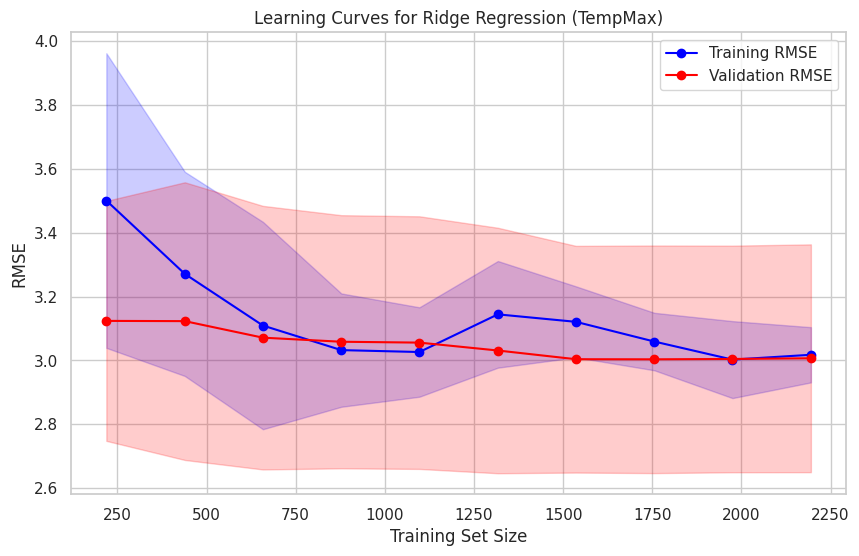

/home/ahzof/hw_ds/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/ahzof/hw_ds/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/ahzof/hw_ds/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/ahzof/hw_ds/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calcula

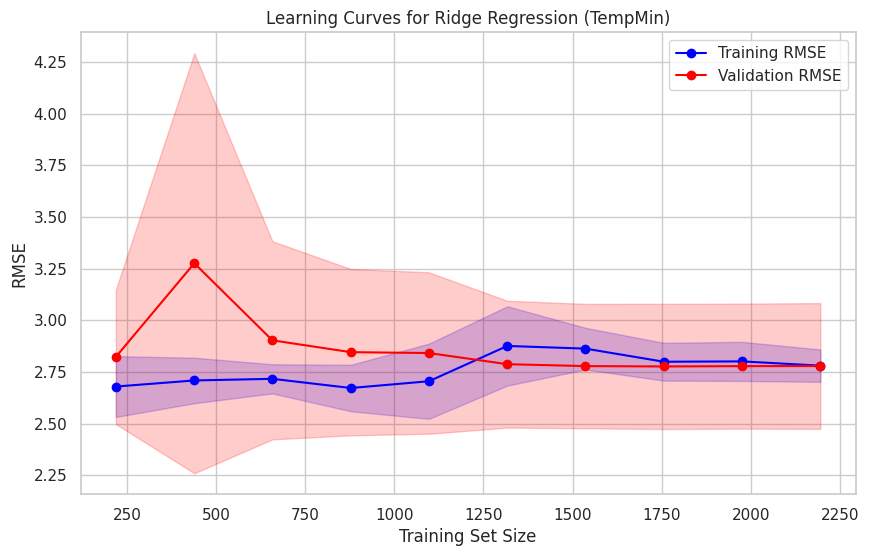

In [141]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer, mean_squared_error

# Define the RMSE scorer
rmse_scorer = make_scorer(mean_squared_error, squared=False)

# Ridge model learning curves for TempMax
train_sizes, train_scores, val_scores = learning_curve(
    ridge_tempmax, X_train_max, residuals_tempmax,
    cv=5, scoring=rmse_scorer,
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

# Calculate mean and std for training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training RMSE')
plt.plot(train_sizes, val_scores_mean, 'o-', color='red', label='Validation RMSE')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, color='red', alpha=0.2)

plt.title('Learning Curves for Ridge Regression (TempMax)')
plt.xlabel('Training Set Size')
plt.ylabel('RMSE')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Repeat the above steps for TempMin Ridge model
train_sizes, train_scores, val_scores = learning_curve(
    ridge_tempmin, X_train_min, residuals_tempmin,
    cv=5, scoring=rmse_scorer,
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training RMSE')
plt.plot(train_sizes, val_scores_mean, 'o-', color='red', label='Validation RMSE')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, color='red', alpha=0.2)

plt.title('Learning Curves for Ridge Regression (TempMin)')
plt.xlabel('Training Set Size')
plt.ylabel('RMSE')
plt.legend(loc='best')
plt.grid(True)
plt.show()


## Cross Validation Before Completion

# Next steps:
- Residual Analysis, no remaining heteroskedasticity issues
- Autocorrelation fix
- Test final model evaluation/maybe try time series models
- Rename variables and clean/simplify notebook
- Documentation and Reporting
- Plot predicted vs actual value